## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df = df.set_index('datetime')

In [7]:
df = df.sort_index()

In [8]:
df = df.resample('1H').sum()

In [9]:
decomposed = seasonal_decompose(df)

In [10]:
df1 = df.copy()

# 2. Analysis

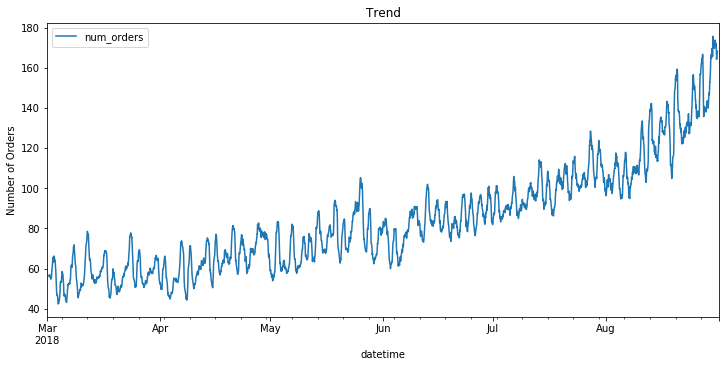

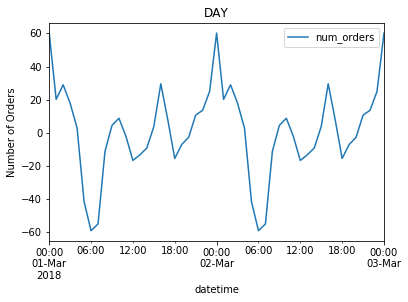

In [11]:
plt.figure(figsize=(10, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of Orders')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.8)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-03 00:00:00'].plot()
plt.title('DAY')
plt.ylabel('Number of Orders')
plt.show()

we can see that there are more orders during the summer and also If we look at the daily breakdown we can see a trand that there are more orders during the night, which peaks at midnight.

In [14]:
df1['mean'] = df1['num_orders'].rolling(15).mean()
df1['std'] = df1['num_orders'].rolling(15).std()

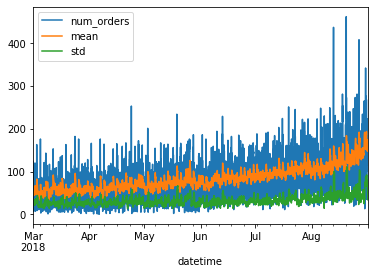

In [15]:
df1.plot()

He we can see that the time series are not stationary, because mean and standart deviation change.

# 3. Training

In [16]:
def make_features(data, lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)  
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(df, 24, 6)

In [18]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train = train.dropna()

In [19]:
train_x = train.drop('num_orders', axis = 1)
train_y = train['num_orders']
test_x = test.drop('num_orders', axis = 1)
test_y = test['num_orders']

In [20]:
lr = LinearRegression()
lr.fit(train_x, train_y) 
lr_test_pred = lr.predict(test_x)
print("RMSE for the testing set:", mean_squared_error(test_y, lr_test_pred) ** 0.5)

RMSE for the testing set: 49.733198597464636


In [21]:
model = RandomForestRegressor()
model.fit(train_x, train_y)
pred = model.predict(test_x)
print("RMSE for the testing set:", mean_squared_error(test_y, pred) ** 0.5)

RMSE for the testing set: 46.23719218525786


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
model = CatBoostRegressor()

In [23]:
model.fit(train_x, train_y)

0:	learn: 38.1484442	total: 52.1ms	remaining: 52.1s
1:	learn: 37.6760579	total: 57.8ms	remaining: 28.8s
2:	learn: 37.1899882	total: 62.2ms	remaining: 20.7s
3:	learn: 36.7349048	total: 88.2ms	remaining: 22s
4:	learn: 36.2861411	total: 94.9ms	remaining: 18.9s
5:	learn: 35.8405745	total: 102ms	remaining: 16.9s
6:	learn: 35.4246274	total: 190ms	remaining: 26.9s
7:	learn: 35.0230022	total: 199ms	remaining: 24.6s
8:	learn: 34.6388315	total: 282ms	remaining: 31.1s
9:	learn: 34.2658737	total: 290ms	remaining: 28.7s
10:	learn: 33.9352096	total: 296ms	remaining: 26.6s
11:	learn: 33.6058237	total: 384ms	remaining: 31.6s
12:	learn: 33.2854179	total: 391ms	remaining: 29.7s
13:	learn: 33.0311488	total: 479ms	remaining: 33.7s
14:	learn: 32.7317796	total: 486ms	remaining: 31.9s
15:	learn: 32.4413858	total: 491ms	remaining: 30.2s
16:	learn: 32.1560038	total: 576ms	remaining: 33.3s
17:	learn: 31.8943890	total: 584ms	remaining: 31.9s
18:	learn: 31.6409002	total: 593ms	remaining: 30.6s
19:	learn: 31.41669

In [24]:
lr_test_pred = model.predict(test_x)
mse= mean_squared_error(test_y, lr_test_pred) 
mse**0.5

44.840442826499604

# 4. Testing

After all I achieved the RMSE of 44.84 which is less then 48, also I concluded that the number of orders tends to increase during summer. Also, the number of orders tends to be increasing during the evening and peaks at midnight.

Regarding the models, I performed fit/predict onto three different models, linearregression model, random forest regressor and CatBoost, out of these three models I achived the lowest RMSE with the CatBoost model, however it also took more time, on the other hand LR model was the quickest with RMSE of 49.73, lastly random forrest regressor achieved RMSE of 46.23, which is lower then required 48 and a bit faster then CatBoost.